### Introduction

In this post we want to present [Our _Image Segmentation_ library](https://github.com/warmspringwinds/tf-image-segmentation)
that is based on _Tensorflow_ and _TF-Slim_ library, share some
insights and thoughts and demonstrate one application of _Image Segmentation_. 

To be more precise, we trained _FCN-32s_, _FCN-16s_ and _FCN-8s_ models
that were described in the paper "Fully Convolutional Networks for Semantic Segmentation"
by Long et al. on _PASCAL VOC_ _Image Segmentation_ dataset and got similar accuracies
compared to results that are demonstrated in the paper.

We provide all the training scripts and scripts to convert _PASCAL VOC_ into
easier-to-use _.tfrecords_ file. Moreover, it is very easy to apply the same
scripts to a custom dataset of your own.

Also, in the repository, you can find all the trained weights and scripts to benchmark
the provided models against _PASCAL VOC_. All the _FCN_ models were trained using
_VGG-16_ network initialization that we took from _TF-Slim_ library.

After that, we demonstrate how to create your own stickers for [Telegram messaging app](https://telegram.org/)
using our pretrained models, as a _Qualitative Evaluation_ of our trained models. While the _Quantitative Results_
are presented in the [repository](https://github.com/warmspringwinds/tf-image-segmentation).

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com).

### Training on PASCAL VOC

The models were trained on Augmented PASCAL VOC dataset which is mentioned in the paper
by Long et al. The _FCN-32s_ model was initialized from _VGG-16_ model and trained for
one hundred thousand iterations. The _FCN-16s_ was initialized with _FCN-32s_ weights and
also trained for one hundred thousand iterations. _FCN-8s_ was trained in the same fashion with
initialization from _FCN-16s_ model.

The reason why the authors of the paper add _skips_ is because the results produced
by the _FCN-32s_ architecture are too coarse and _skips_ are added to lower layers
of the _VGG-16_ network which were affected by smaller number of _max-pooling_ layers
of _VGG-16_ and, therefore, can give finer predictions while still taking into
account more reliable higher level predictions.

During the training, we noticed that the cross entropy loss was decreasing, after we
added _skips_ that _FCN-16s_ and _FCN-8s_ models have. Also, during the training
we randomly change the scale of the training image. Due to this fact, we had to 
normalize the cross entropy loss, because, otherwise, it was hard to understand
if the loss is decreasing (we had different number of pixels on each iteration stage as
a result of random scaling). Here you can see the cross entropy loss plot:
![alt text](data/imgs/cross_entropy.png)

We trained with a _batch size_ one and used _Adam optimizer_. It is important to state here, that
although we trained with a _batch size_ one, which might sound crazy -- it actually means that
after we do forward propagation for one image, we get predictions for each pixel. Then, we compute the
pixel-wise cross-entropy. So, _batch size_ one only means that we use one image per iteration, which consists
of pixel-wise training samples.

Overall, we achieved comparable or better performance with the original paper. You can find our
results in the [repository](https://github.com/warmspringwinds/tf-image-segmentation).

### Qualitative results

In order to show some results of Segmentation produced by aforementioned models,
let's apply the trained models to unseen images that contain some objects that
represent one of PASCAL VOC classes. After we get segmentation masks, we create
a countour for our segmentation masks, to create stickers and we save everything as
a _png_ file with _alpha_ channel, to display only object and make background transparent.

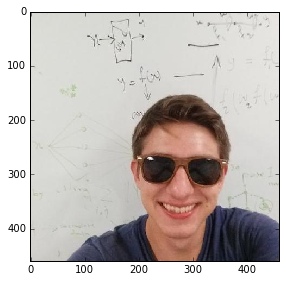

/home/dpakhom1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


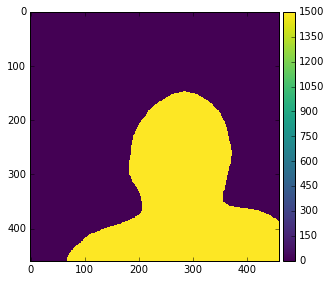

In [1]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

sys.path.append("tf-image-segmentation/")
sys.path.append("/home/dpakhom1/workspace/my_models/slim/")

fcn_16s_checkpoint_path = '/home/dpakhom1/tf_projects/segmentation/model_fcn8s_final.ckpt'

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

slim = tf.contrib.slim

from tf_image_segmentation.models.fcn_8s import FCN_8s
from tf_image_segmentation.utils.inference import adapt_network_for_any_size_input
from tf_image_segmentation.utils.pascal_voc import pascal_segmentation_lut

number_of_classes = 21

image_filename = 'me.jpg'

#image_filename = 'small_cat.jpg'

image_filename_placeholder = tf.placeholder(tf.string)

feed_dict_to_use = {image_filename_placeholder: image_filename}

image_tensor = tf.read_file(image_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)

# Fake batch for image and annotation by adding
# leading empty axis.
image_batch_tensor = tf.expand_dims(image_tensor, axis=0)

# Be careful: after adaptation, network returns final labels
# and not logits
FCN_8s = adapt_network_for_any_size_input(FCN_8s, 32)


pred, fcn_16s_variables_mapping = FCN_8s(image_batch_tensor=image_batch_tensor,
                                          number_of_classes=number_of_classes,
                                          is_training=False)

# The op for initializing the variables.
initializer = tf.local_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(initializer)

    saver.restore(sess, "/home/dpakhom1/tf_projects/segmentation/model_fcn8s_final.ckpt")
    
    image_np, pred_np = sess.run([image_tensor, pred], feed_dict=feed_dict_to_use)
    
    io.imshow(image_np)
    io.show()
    
    io.imshow(pred_np.squeeze())
    io.show()

Let's display the look up table with mapping from class number to the name of the _PASCAL VOC_ class:

In [2]:
pascal_segmentation_lut()

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'potted-plant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv/monitor',
 255: 'ambigious'}

Now, let's create a contour for our segmentation to make it look like an actual sticker.
We save the file as _png_ with an _alpha_ channel that is set up to make background transparent.
We still visualize the final segmentation on the black backgound to make the the countour
visible. Otherwise, it is hard to see it, because the background of the page is white.

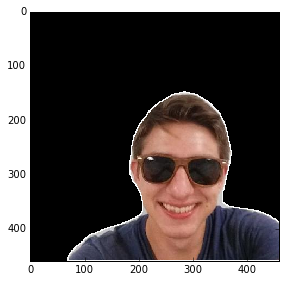

In [3]:
# Eroding countour

import skimage.morphology

prediction_mask = (pred_np.squeeze() == 15)

# Let's apply some morphological operations to
# create the contour for our sticker

cropped_object = image_np * np.dstack((prediction_mask,) * 3)

square = skimage.morphology.square(5)

temp = skimage.morphology.binary_erosion(prediction_mask, square)

negative_mask = (temp != True)

eroding_countour = negative_mask * prediction_mask

eroding_countour_img = np.dstack((eroding_countour, ) * 3)

cropped_object[eroding_countour_img] = 248

png_transparancy_mask = np.uint8(prediction_mask * 255)

image_shape = cropped_object.shape

png_array = np.zeros(shape=[image_shape[0], image_shape[1], 4], dtype=np.uint8)

png_array[:, :, :3] = cropped_object

png_array[:, :, 3] = png_transparancy_mask

io.imshow(cropped_object)

io.imsave('sticker_cat.png', png_array)

Now, let's repeat the same thing for another image. I will duplicate the code, because I am lazy.
But images can be stacked into batches for more efficient processing (if they are of the same size though).

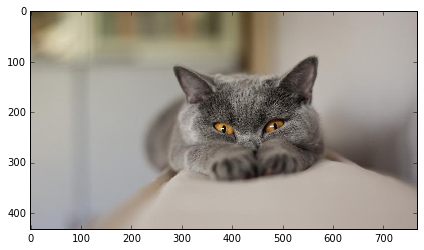

/home/dpakhom1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


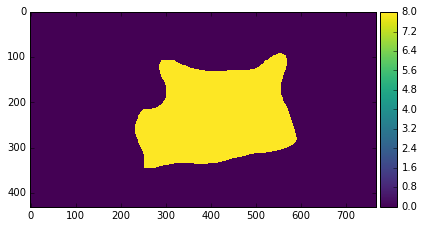

In [1]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

sys.path.append("tf-image-segmentation/")
sys.path.append("/home/dpakhom1/workspace/my_models/slim/")

fcn_16s_checkpoint_path = '/home/dpakhom1/tf_projects/segmentation/model_fcn8s_final.ckpt'

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

slim = tf.contrib.slim

from tf_image_segmentation.models.fcn_8s import FCN_8s
from tf_image_segmentation.utils.inference import adapt_network_for_any_size_input
from tf_image_segmentation.utils.pascal_voc import pascal_segmentation_lut

number_of_classes = 21

image_filename = 'small_cat.jpg'

image_filename_placeholder = tf.placeholder(tf.string)

feed_dict_to_use = {image_filename_placeholder: image_filename}

image_tensor = tf.read_file(image_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)

# Fake batch for image and annotation by adding
# leading empty axis.
image_batch_tensor = tf.expand_dims(image_tensor, axis=0)

# Be careful: after adaptation, network returns final labels
# and not logits
FCN_8s = adapt_network_for_any_size_input(FCN_8s, 32)


pred, fcn_16s_variables_mapping = FCN_8s(image_batch_tensor=image_batch_tensor,
                                          number_of_classes=number_of_classes,
                                          is_training=False)

# The op for initializing the variables.
initializer = tf.local_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(initializer)

    saver.restore(sess, "/home/dpakhom1/tf_projects/segmentation/model_fcn8s_final.ckpt")
    
    image_np, pred_np = sess.run([image_tensor, pred], feed_dict=feed_dict_to_use)
    
    io.imshow(image_np)
    io.show()
    
    io.imshow(pred_np.squeeze())
    io.show()

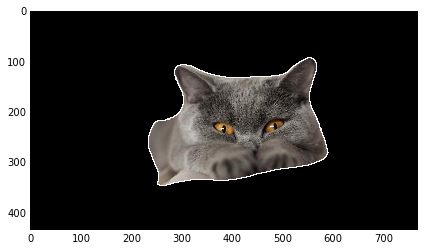

In [2]:
# Eroding countour

import skimage.morphology

prediction_mask = (pred_np.squeeze() == 8)

# Let's apply some morphological operations to
# create the contour for our sticker

cropped_object = image_np * np.dstack((prediction_mask,) * 3)

square = skimage.morphology.square(5)

temp = skimage.morphology.binary_erosion(prediction_mask, square)

negative_mask = (temp != True)

eroding_countour = negative_mask * prediction_mask

eroding_countour_img = np.dstack((eroding_countour, ) * 3)

cropped_object[eroding_countour_img] = 248

png_transparancy_mask = np.uint8(prediction_mask * 255)

image_shape = cropped_object.shape

png_array = np.zeros(shape=[image_shape[0], image_shape[1], 4], dtype=np.uint8)

png_array[:, :, :3] = cropped_object

png_array[:, :, 3] = png_transparancy_mask

io.imshow(cropped_object)

io.imsave('sticker_cat.png', png_array)

After manually resizing and cropping images to the size of _512_ by _512_, which can
be automated, we created stickers for _Telegram_ using [Telegram sticker bot](https://telegram.org/blog/stickers-revolution).

Here you can see how they look in _Telegram_ with the transparency and our
countour:

![alt text](data/imgs/mobile_screen_shot_2.png)

![alt text](data/imgs/mobile_screen_shot_1.png)

### Conclusion and Discussion

In this blog post, we presented a library with implemented and trained models
from the paper "Fully Convolutional Networks for Semantic Segmentation"
by Long et al, namely _FCN-32s_, _FCN-16s_, _FCN-8s_ and qualitatively evaluated
them by using them to create _Telegram stickers_.

Segmentation can be improved for more complicated image with application of Conditional Random
Fields (CRFs) as a post-processing stage, which we described in the previous post.